In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# models
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingRegressor, RandomForestRegressor, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
# model evaluation
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_curve, auc, f1_score
# dataset visulization
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
# data resampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
# feature selection
from sklearn.feature_selection import VarianceThreshold, RFE, mutual_info_classif, SelectKBest
from sklearn.linear_model import LassoCV, Lasso
from sklearn.preprocessing import StandardScaler
# model selection
from sklearn.model_selection import StratifiedKFold
from imblearn.ensemble import BalancedRandomForestClassifier 

# Data Loading and process
- load data and check pupulation size
- split data to train and test data
- visualize high-dimensional datase by t-SNE and PCA

### load data and check pupulation size
- df: original data
- df_rename: 'Bankrupt?' : 'target', features: Attr1~Attr95

In [2]:
# Read in dataset
df = pd.read_csv('data.csv')
df_rename = df.copy()
population_size = len(df)
# Rename columns
df.rename(columns={'Bankrupt?' : 'target'},inplace=True)
index = 0
for col in df_rename.columns:
    if col == 'Bankrupt?':
        df_rename.rename(columns={col : 'target'},inplace=True)
    else:
        df_rename.rename(columns={col : 'Attr'+str(index)},inplace=True)
    index += 1    

# Checking data population
print("data shape:",df_rename.shape)
# Checking target incidence
print("\ndata incidence",df_rename.target.value_counts(normalize=True))

#basetable.columns

data shape: (6819, 96)

data incidence 0    0.967737
1    0.032263
Name: target, dtype: float64


$\implies$ 3% of target '1': imbalanced data</br>
$\implies$ 96 features: high-dimensional dataset


array([[<AxesSubplot:title={'center':'target'}>,
        <AxesSubplot:title={'center':'Attr1'}>,
        <AxesSubplot:title={'center':'Attr2'}>,
        <AxesSubplot:title={'center':'Attr3'}>,
        <AxesSubplot:title={'center':'Attr4'}>,
        <AxesSubplot:title={'center':'Attr5'}>,
        <AxesSubplot:title={'center':'Attr6'}>,
        <AxesSubplot:title={'center':'Attr7'}>,
        <AxesSubplot:title={'center':'Attr8'}>,
        <AxesSubplot:title={'center':'Attr9'}>],
       [<AxesSubplot:title={'center':'Attr10'}>,
        <AxesSubplot:title={'center':'Attr11'}>,
        <AxesSubplot:title={'center':'Attr12'}>,
        <AxesSubplot:title={'center':'Attr13'}>,
        <AxesSubplot:title={'center':'Attr14'}>,
        <AxesSubplot:title={'center':'Attr15'}>,
        <AxesSubplot:title={'center':'Attr16'}>,
        <AxesSubplot:title={'center':'Attr17'}>,
        <AxesSubplot:title={'center':'Attr18'}>,
        <AxesSubplot:title={'center':'Attr19'}>],
       [<AxesSubplot:title=

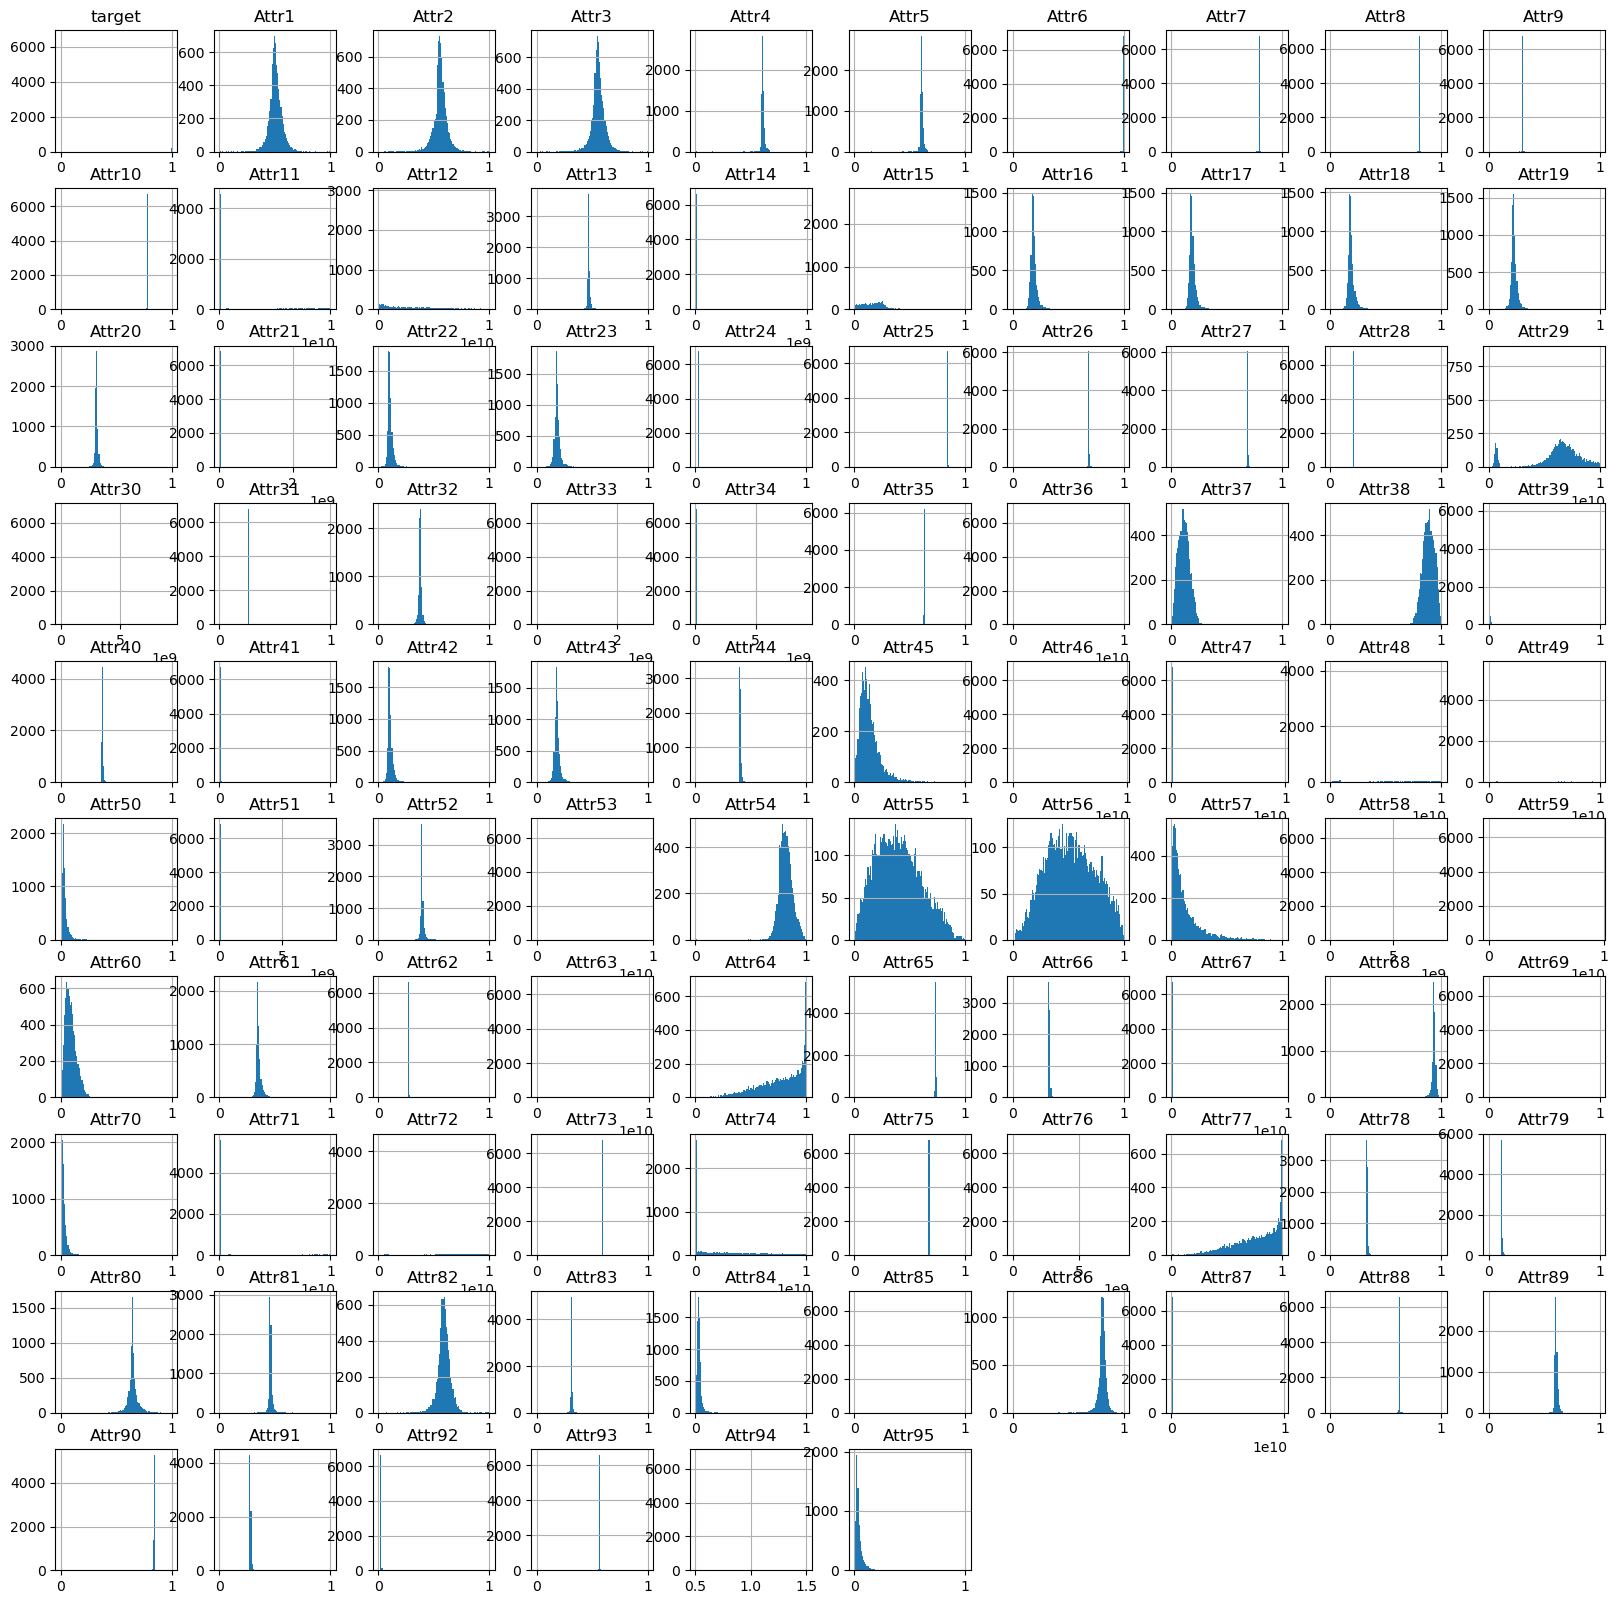

In [39]:
df_rename.hist(bins=100, figsize=(20, 20))

### split data to train and test data
- X: all features data
- y: target data
- X_train, X_test, y_train, y_teat splited by 'train_test_split' with test-size 0.3

In [3]:
# Assign Data to X and y
X = df_rename.drop(columns='target')
y = df_rename.target

## Resample Imbalanced data
- Using imblearn library </br>
  1. Undersampling with RandomForest: </br>This technique eliminates or deletes the data points of the majority class to make an equal ratio of major and minor classes.There is a various method for undersampling like Tomek’s links, EditedNearestNeighbours, CondensedNearestNeighbour, InstanceHardnessThreshold, etc.
  2. Oversampling: </br>This technique redistributes randomly the minority class data points to increase the ratio in the dataset.It duplicates the existing data points of minority class and equalizes the ratio of majority and minority class.
  3. SMOTE (Synthetic Minority Oversampling Technique):</br>SMOTE selects the data points of the minority class in feature space to draw a line between those points and generate new points along with the line. Thus this technique synthesizes new data points for minority class and oversample that class.</br>This is the most effective method for oversampling.

In [78]:
# Find the best resampled dataset
models = [RandomForestClassifier(), LogisticRegression(), KNeighborsClassifier()]
models_name = ['RandomForestClassifier','LogisticRegression', 'KNeighborsClassifier']
data_name = ['Original','underSampling','overSampling','SMOTE']
models_f1Score = pd.DataFrame(columns=models_name, index=data_name)
models_acurrency = pd.DataFrame(columns=models_name, index=data_name)

In [63]:
def ROC_AUC_Curve(probabilities,y_test,plot_title,ax):
    # select the probabilities for label 1.0
    y_proba = probabilities[:,1]
    # calculate false positive rate and true positive rate at different thresholds
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_proba, pos_label=1)
    # calculate AUC
    roc_auc = auc(false_positive_rate,true_positive_rate)
    ax.set_title(plot_title)
    # plot the false positive rate on the x axis and the true positive rate on the y axis
    roc_plot = ax.plot(false_positive_rate,
                    true_positive_rate,
                    label='AUC = {:0.2f}'.format(roc_auc))
    ax.legend(loc=0)
    ax.plot([0,1], [0,1], ls='--')
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate');
    return ax

In [76]:
def testModels(models, models_name, X, y, data_name, f1Score, acurrency):
    f1Score.loc[data_name] = np.zeros(len(models))
    acurrency.loc[data_name] = np.zeros(len(models))
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.3,
        random_state=42,
        stratify=y
        )
    for md_name, md in zip(models_name,models):
        md.fit(X_train,y_train)
        y_pre=md.predict(X_test)
        f1Score[md_name][data_name] = f1_score(y_test, y_pre, average='macro')
        acurrency[md_name][data_name] = accuracy_score(y_test, md.predict(X_test))
        probabilities = md.predict_proba(X_test)
        fig, (ax1, ax2) = plt.subplots(1, 2, sharex = False, figsize=(12, 3), dpi = 72)
        #print ROC_AUC_Curve
        plot_title = md_name+"("+data_name+") F1s:"+format(f1Score[md_name][data_name],'.2f')
        ROC_AUC_Curve(probabilities,y_test,plot_title,ax1)
        #print confusion matrix
        c_matrix = confusion_matrix(y_test,y_pre)
        ax2.set_title(plot_title)
        disp = ConfusionMatrixDisplay(confusion_matrix=c_matrix,display_labels=["Not bankrupt", "Is bankrupt"])
        disp.plot(ax=ax2)
        #ax2.plot()
        fig.show()

/var/folders/kn/74_zgp_92dq3kqn02k33f_xr0000gn/T/ipykernel_28564/1696818173.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/zoeychiu/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/var/folders/kn/74_zgp_92dq3kqn02k33f_xr0000gn/T/ipykernel_28564/1696818173.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var

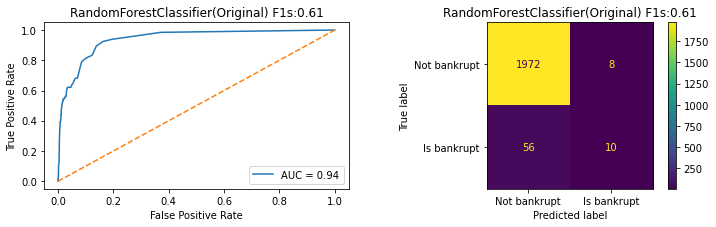

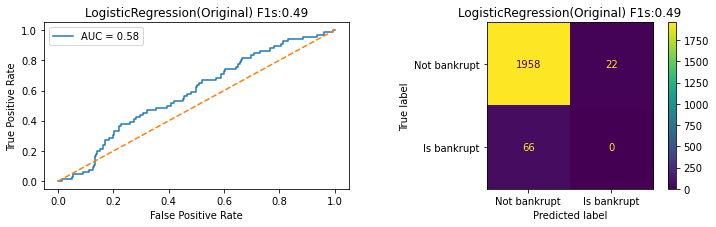

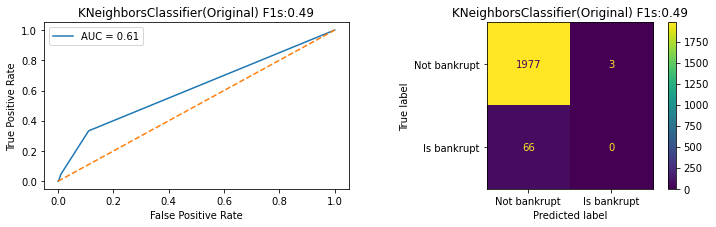

In [79]:
testModels(models, models_name, X, y, 'Original', models_f1Score, models_acurrency)

# to-do Divya : piechat of imbalance data 

# to-do Ginny: Undersampling with RandomForest

X_underSampling's shape: (440, 95) y_underSampling's shape: (440,)
y_underSampling:
 0    0.5
1    0.5
Name: target, dtype: float64


/var/folders/kn/74_zgp_92dq3kqn02k33f_xr0000gn/T/ipykernel_28564/1696818173.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/kn/74_zgp_92dq3kqn02k33f_xr0000gn/T/ipykernel_28564/1696818173.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/kn/74_zgp_92dq3kqn02k33f_xr0000gn/T/ipykernel_28564/1696818173.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


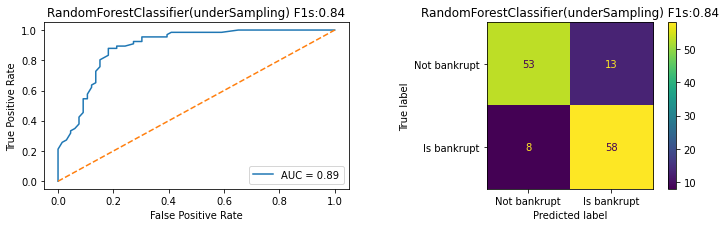

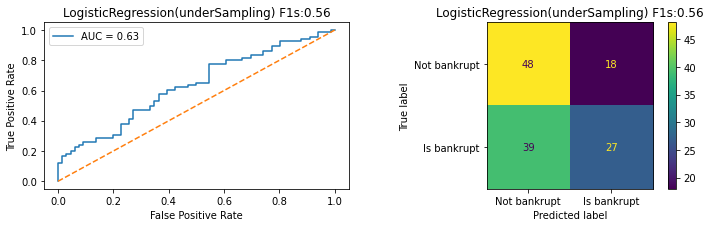

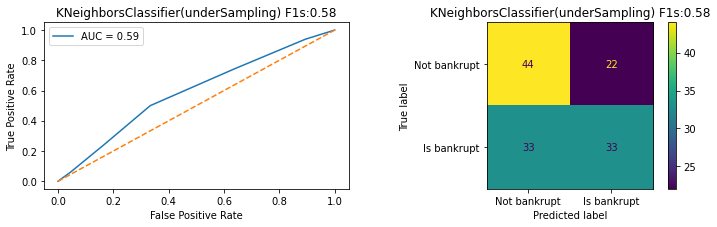

In [80]:
# Undersampling
rus = RandomUnderSampler(random_state=0)
X_underSampling, y_underSampling = rus.fit_resample(X, y)
print("X_underSampling's shape:", X_underSampling.shape,"y_underSampling's shape:", y_underSampling.shape)
print("y_underSampling:\n",y_underSampling.value_counts(normalize=True))
testModels(models, models_name, X_underSampling, y_underSampling, 'underSampling', models_f1Score, models_acurrency)

### Oversampling

X_overSampling's shape: (13198, 95) y_overSampling's shape: (13198,)
y_overSampling:
 1    0.5
0    0.5
Name: target, dtype: float64


/var/folders/kn/74_zgp_92dq3kqn02k33f_xr0000gn/T/ipykernel_28564/1696818173.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/zoeychiu/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/var/folders/kn/74_zgp_92dq3kqn02k33f_xr0000gn/T/ipykernel_28564/1696818173.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var

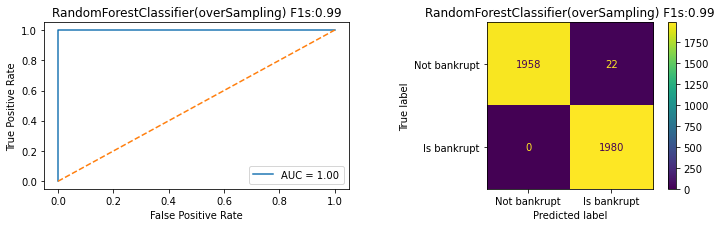

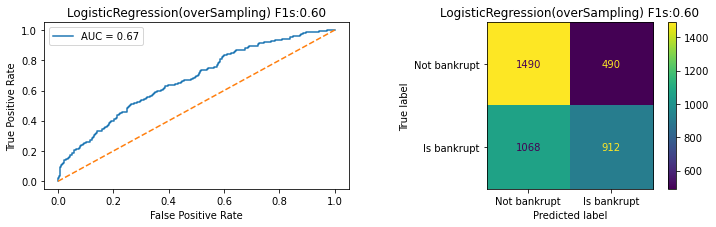

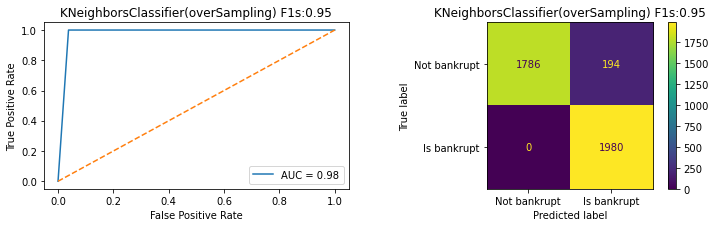

In [81]:
# Oversampling
ros = RandomOverSampler(random_state=0)
X_overSampling, y_overSampling = ros.fit_resample(X, y)
print("X_overSampling's shape:", X_overSampling.shape,"y_overSampling's shape:", y_overSampling.shape)
print("y_overSampling:\n",y_overSampling.value_counts(normalize=True))
testModels(models, models_name, X_overSampling, y_overSampling, 'overSampling', models_f1Score, models_acurrency)

### SMOTE

X_SMOTE's shape: (13198, 95) y_SMOTE's shape: (13198,)
y_SMOTE:
 1    0.5
0    0.5
Name: target, dtype: float64


/var/folders/kn/74_zgp_92dq3kqn02k33f_xr0000gn/T/ipykernel_28564/1696818173.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/zoeychiu/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/var/folders/kn/74_zgp_92dq3kqn02k33f_xr0000gn/T/ipykernel_28564/1696818173.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var

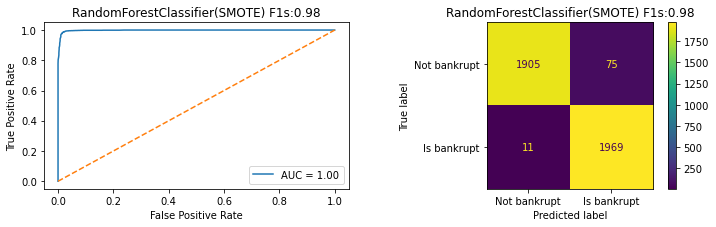

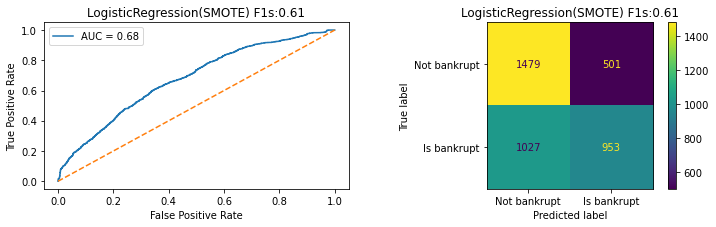

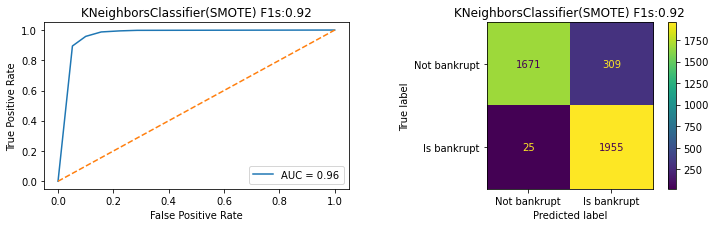

In [82]:
# SMOTE
sm = SMOTE(random_state=0)
X_SMOTE, y_SMOTE = sm.fit_resample(X, y)
print("X_SMOTE's shape:", X_SMOTE.shape,"y_SMOTE's shape:", y_SMOTE.shape)
print("y_SMOTE:\n",y_SMOTE.value_counts(normalize=True))
testModels(models, models_name, X_SMOTE, y_SMOTE, 'SMOTE', models_f1Score, models_acurrency)

# to-do Diyva: give an explanation why not choosing Oversampling but SMOTE better

In [83]:
X_resample = X_overSampling.copy()
y_resample = y_overSampling.copy()

In [84]:
sum(X_resample.isna().sum()/len(y_resample))

0.0

In [85]:
X_resample.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr86,Attr87,Attr88,Attr89,Attr90,Attr91,Attr92,Attr93,Attr94,Attr95
0,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,0.780284,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,0.781241,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,0.781550,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


# Feature Selectioon
- Removing highly correlated features -> change to Diyva's way
- Removing highly  VIF-scored features -> add from Diyva
- Selecting for Model Accuracy
- Selecting by Mutual Information

# to-do Yunhan: Removing highly hightly VIF-scored features -> add from Diyva

In [23]:
# Calculate the correlation matrix and take the absolute value
corr_df = X_resample.corr().abs()
# Create a True/False mask and apply it
mask = np.triu(np.ones_like(corr_df, dtype=bool))
tri_df = corr_df.mask(mask)
# List column names of high correlated features (r > 0.9)
to_drop = [c for c in tri_df.columns if any(tri_df[c] >  0.9)]
# Drop the features in the to_drop list
data_removeHighCorr = X_resample.drop(to_drop, axis=1)

In [38]:
data_removeHighCorr.shape

(13198, 74)

In [34]:
def drop_vif(df,vifIndex):    
    vif, tolerance = {}, {}
    # all the features that you want to examine
    for feature in df.columns:
        # extract all the other features you will regress against
        X = [f for f in features if f != feature]        
        X, y = df[X], df[feature]
        # extract r-squared from the fit
        r2 = LinearRegression().fit(X, y).score(X, y)                
        # calculate tolerance
        tolerance[feature] = 1 - r2
        # calculate VIF
        vif[feature] = 1/(tolerance[feature])
    # return drop features of VIF > vifIndex
    to_drop = [f for f in df.columns if vif[f] > vifIndex]    
    return to_drop

In [35]:
# Drop the features whose vif is greater than 5
data_remove5VIF = data_removeHighCorr.drop(drop_vif(data_removeHighCorr,5), axis=1)

/var/folders/kn/74_zgp_92dq3kqn02k33f_xr0000gn/T/ipykernel_28564/1923136156.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  vif[feature] = 1/(tolerance[feature])


In [37]:
data_remove5VIF.shape

(13198, 49)

/var/folders/kn/74_zgp_92dq3kqn02k33f_xr0000gn/T/ipykernel_28564/1696818173.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/zoeychiu/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/var/folders/kn/74_zgp_92dq3kqn02k33f_xr0000gn/T/ipykernel_28564/1696818173.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var

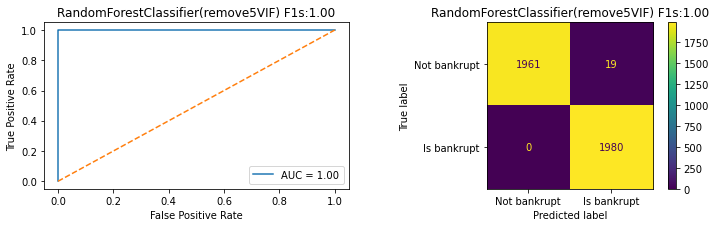

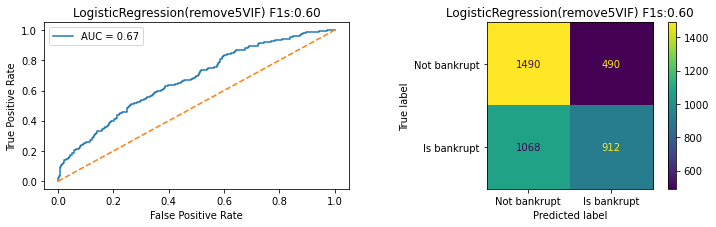

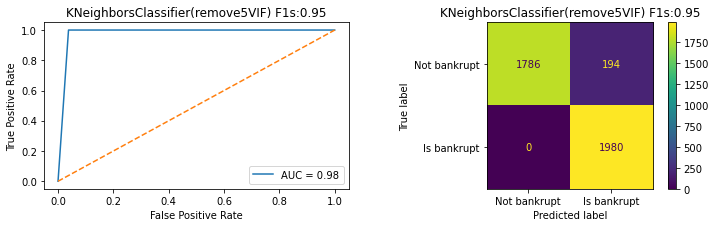

In [86]:
testModels(models, models_name, data_remove5VIF, y_resample, 'remove5VIF', models_f1Score, models_acurrency)

### Selecting for Model Accuracy
- StandardScaler
- LassoCV
- GradientBoostingRegressor
- RandomForestRegressor

/var/folders/kn/74_zgp_92dq3kqn02k33f_xr0000gn/T/ipykernel_28564/1696818173.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/zoeychiu/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/var/folders/kn/74_zgp_92dq3kqn02k33f_xr0000gn/T/ipykernel_28564/1696818173.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var

,RandomForestClassifier,LogisticRegression,KNeighborsClassifier
Original,0.611064,0.489011,0.491424
underSampling,0.84068,0.556969,0.58042
overSampling,0.994444,0.598001,0.950892
SMOTE,0.978277,0.607211,0.915221
remove5VIF,0.995202,0.598001,0.950892
StandardScaler,0.994949,0.598001,0.950892


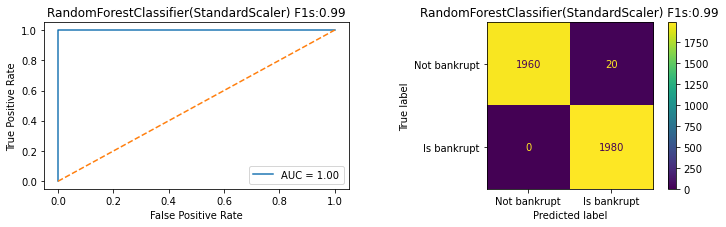

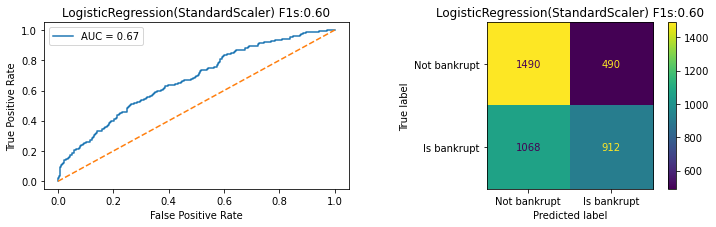

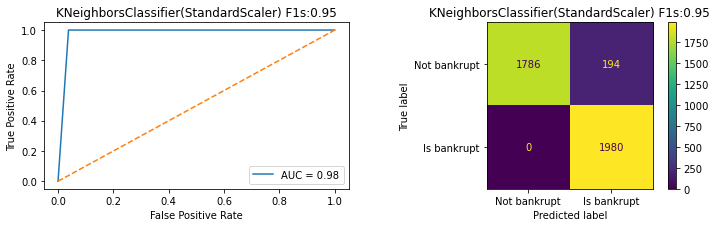

In [87]:
scaler = StandardScaler()
# Fit the scaler on the training features and transform these in one go
X_resample_std = scaler.fit_transform(X_resample)

testModels(models , models_name, data_removeHighCorr, y_resample,'StandardScaler',models_f1Score, models_acurrency)
models_f1Score

In [88]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resample,
    y_resample,
    test_size=0.3,
    random_state=42,
    stratify=y_resample
    )

In [89]:
# Create and fit the LassoCV model on the training set
lcv = LassoCV()
lcv.fit(X_train, y_train)
print(f'Optimal alpha = {lcv.alpha_:.3f}')

# Calculate R squared on the test set
r_squared = lcv.score(X_test, y_test)
print(f'The model explains {r_squared:.1%} of the test set variance')

# Create a mask for coefficients not equal to zero
lcv_mask = lcv.coef_ != 0
print(f'{sum(lcv_mask)} features out of {len(lcv_mask)} selected')


Optimal alpha = 248152.858
The model explains 8.9% of the test set variance
22 features out of 95 selected


In [90]:
# Select 10 features with RFE on a GradientBoostingRegressor, drop 3 features on each step
rfe_gb = RFE(estimator=GradientBoostingRegressor(), 
             n_features_to_select=10, step=10, verbose=1)
rfe_gb.fit(X_train, y_train)

Fitting estimator with 95 features.
Fitting estimator with 85 features.
Fitting estimator with 75 features.
Fitting estimator with 65 features.
Fitting estimator with 55 features.
Fitting estimator with 45 features.
Fitting estimator with 35 features.
Fitting estimator with 25 features.
Fitting estimator with 15 features.


RFE(estimator=GradientBoostingRegressor(), n_features_to_select=10, step=10,
    verbose=1)

In [91]:
# Print the features and their ranking (high = dropped early on)
#print(dict(zip(X_resample.columns, rfe_gb.ranking_)))

# Calculate the R squared on the test set
r_squared = rfe_gb.score(X_test, y_test)
print(f'The model can explain {r_squared:.1%} of the variance in the test set')

# Assign the support array to gb_mask
gb_mask = rfe_gb.support_

The model can explain 81.5% of the variance in the test set


In [92]:
# Select 10 features with RFE on a RandomForestRegressor, drop 3 features on each step
rfe_rf = RFE(estimator=RandomForestRegressor(), 
             n_features_to_select=10, step=10, verbose=1)
rfe_rf.fit(X_train, y_train)

Fitting estimator with 95 features.
Fitting estimator with 85 features.
Fitting estimator with 75 features.
Fitting estimator with 65 features.
Fitting estimator with 55 features.
Fitting estimator with 45 features.
Fitting estimator with 35 features.
Fitting estimator with 25 features.
Fitting estimator with 15 features.


RFE(estimator=RandomForestRegressor(), n_features_to_select=10, step=10,
    verbose=1)

In [93]:
# Print the features and their ranking (high = dropped early on)
#print(dict(zip(X_resample.columns, rfe_rf.ranking_)))
# Calculate the R squared on the test set
r_squared = rfe_rf.score(X_test, y_test)
print(f'The model can explain {r_squared:.1%} of the variance in the test set')
# Assign the support array to rf_mask
rf_mask = rfe_rf.support_

The model can explain 97.2% of the variance in the test set


In [94]:
scaler = StandardScaler()
lm = Lasso(alpha=248152.858)
# Sum the votes of the three models
votes = np.sum([lcv_mask, rf_mask, gb_mask], axis=0)
print("votes:",votes)
# Create a mask for features selected by at least 3 model
meta_mask = votes >= 2
# Apply the dimensionality reduction on X
X_reduced = X_resample.loc[:, meta_mask]
# Plug the reduced dataset into a linear regression pipeline
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X_reduced, y_resample, test_size=0.3, random_state=0)
lm.fit(scaler.fit_transform(X_train_reduced), y_train_reduced)
r_squared = lm.score(scaler.transform(X_test_reduced), y_test_reduced)
print(f'The model can explain {r_squared:.1%} of the variance in the test set using {len(lm.coef_)} features.')

votes: [0 0 0 0 0 0 0 0 1 2 1 1 0 1 0 0 0 0 2 0 0 0 0 0 0 0 0 0 1 1 0 0 0 2 2 3 0
 0 0 2 0 0 0 0 0 2 1 1 1 0 1 0 1 0 0 0 1 1 1 0 0 0 2 0 0 0 1 1 0 0 1 2 0 2
 0 1 0 0 0 0 0 0 0 0 0 2 1 0 0 0 0 0 0 0 0]
The model can explain -0.2% of the variance in the test set using 11 features.


$\implies$ the perfoemance is low

/var/folders/kn/74_zgp_92dq3kqn02k33f_xr0000gn/T/ipykernel_28564/1696818173.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/kn/74_zgp_92dq3kqn02k33f_xr0000gn/T/ipykernel_28564/1696818173.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/kn/74_zgp_92dq3kqn02k33f_xr0000gn/T/ipykernel_28564/1696818173.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


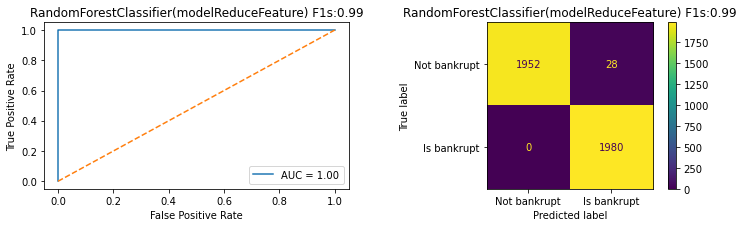

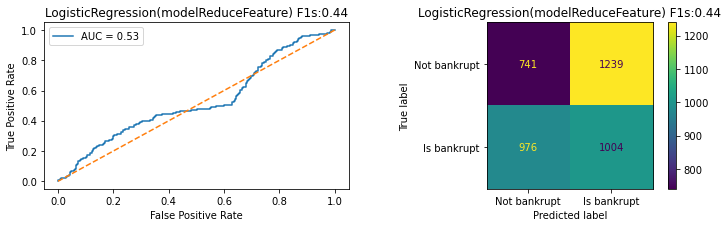

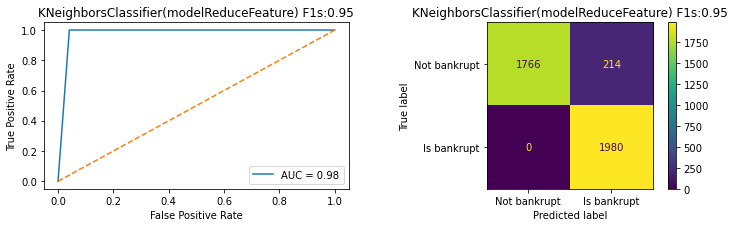

In [95]:
testModels(models , models_name, X_reduced, y_resample,'modelReduceFeature',models_f1Score, models_acurrency)

### Selecting by Mutual Infromation

Text(0, 0.5, 'Mutual Information')

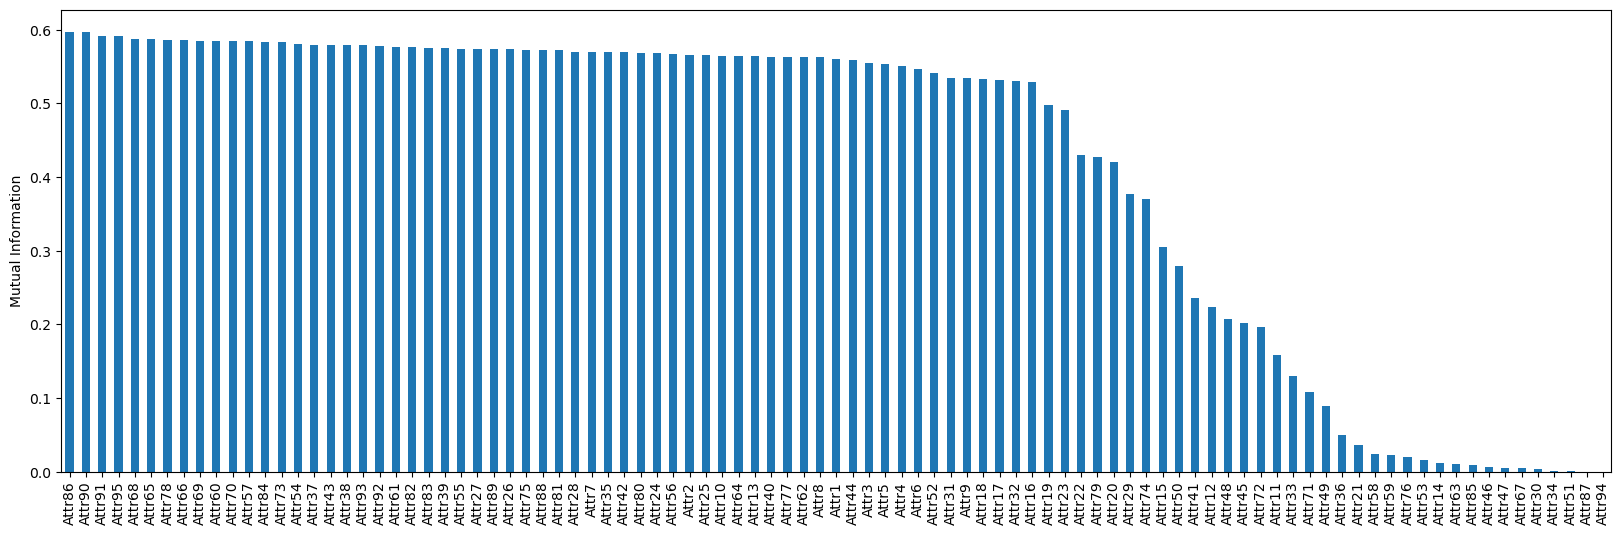

In [96]:
# the less mi value, the less information we can get from
mi = mutual_info_classif(X_resample, y_resample)
miseries = pd.Series(mi)
miseries.index = X_resample.columns
miseries.sort_values(ascending=False).plot.bar(figsize=(20, 6))
plt.ylabel('Mutual Information')

In [97]:
# select features
k_best = SelectKBest(mutual_info_classif, k=40).fit(X_resample, y_resample)
X_kBest = k_best.transform(X_resample)
# display features
#X_resample.columns[k_best.get_support()]

/var/folders/kn/74_zgp_92dq3kqn02k33f_xr0000gn/T/ipykernel_28564/1696818173.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/zoeychiu/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/var/folders/kn/74_zgp_92dq3kqn02k33f_xr0000gn/T/ipykernel_28564/1696818173.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var

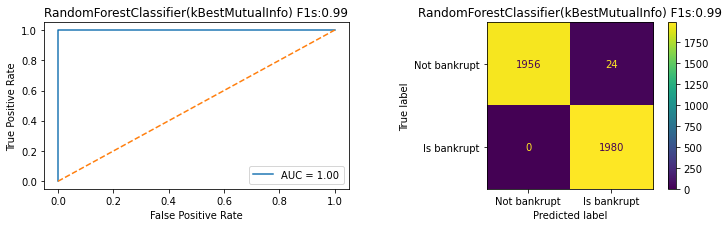

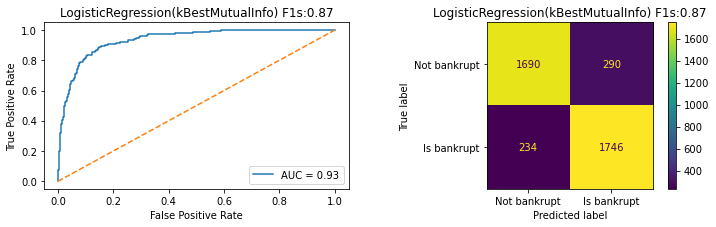

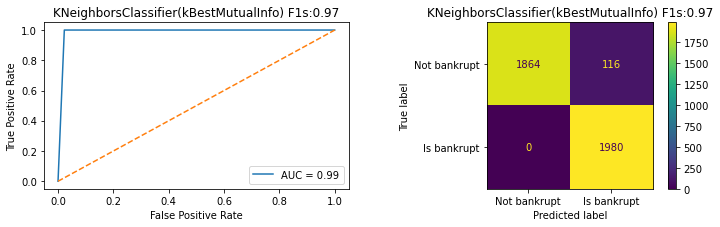

In [98]:
testModels(models, models_name, X_kBest, y_resample,'kBestMutualInfo',models_f1Score, models_acurrency)

In [99]:
models_f1Score

,RandomForestClassifier,LogisticRegression,KNeighborsClassifier
Original,0.611064,0.489011,0.491424
underSampling,0.84068,0.556969,0.58042
overSampling,0.994444,0.598001,0.950892
SMOTE,0.978277,0.607211,0.915221
remove5VIF,0.995202,0.598001,0.950892
StandardScaler,0.994949,0.598001,0.950892
modelReduceFeature,0.992929,0.438178,0.945801
kBestMutualInfo,0.993939,0.86765,0.970682


In [100]:
models_acurrency

,RandomForestClassifier,LogisticRegression,KNeighborsClassifier
Original,0.968719,0.956989,0.966276
underSampling,0.840909,0.568182,0.583333
overSampling,0.994444,0.606566,0.95101
SMOTE,0.978283,0.614141,0.915657
remove5VIF,0.995202,0.606566,0.95101
StandardScaler,0.994949,0.606566,0.95101
modelReduceFeature,0.992929,0.440657,0.94596
kBestMutualInfo,0.993939,0.867677,0.970707


# to-do Diyva: testModels with Hyperparameters and compare with no Hyperparameters

# to-do Ginny: model evaluation

# to-do Together: Conclusion